## Bank Term Deposit Acceptance forecasting

Obiettivo di questo assignment è la valutazione delle competenze tecniche del candidato e la sua modalità di approccio ad un problema di Data Science. Nello specifico è richiesto di sviluppare un modello predittivo in grado di indicare se un cliente intercettato da una campagna di marketing da parte di una banca decide di sottoscrivere o meno un deposito bancario a termine (bank term deposit).

#### Dataset: ####

All'interno della cartella **data**  viene fornito il file **bank-dataset.csv** che contiene le campagne marketing telefoniche effettuate da una banca per proporre l'acquisto del prodotto bancario.
I dettagli del dataset sono forniti all'interno del file: **bank-names.txt**.
La variabile target che indica se il cliente accetta o meno la sottoscrizione del deposito bancario è contenuta nel medesimo file con field name "y".

#### Assignement: ####

Richiesta di questo assignment è la costruzione di un modello predittivo con performance soddisfacenti per il candidato dando evidenza di tutti gli step tipici che dovrebbero essere affrontati in un progetto di Data Science: dalla pulizia e preparazione del dato fino al testing delle performance del modello costruito.

Il notebook svolto dovrà essere opportunamente commentato e dovrà essere consegnato tramite condivisione di un repository github personale accessibile che ne permetta la riproduzione.

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
from pathlib import Path
import yaml
from datetime import datetime
from typing import Tuple, Union

from xgboost import XGBClassifier, XGBRegressor
from hyperopt import Trials, fmin, hp, tpe
from hyperopt.pyll import scope

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.utils import resample
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
SEED = 42 # set for reproducibility

## Data Loader
The data are loaded and parsed from the .csv file and store into a tf.data object



In [2]:
def load_df(data_path:str='data/bank-dataset.csv', features_path:str='data/features.yaml', raw:bool=False, debug:bool=False) -> tuple:
    """ Load the data.csv as pandas DataFrame and clean the dataset

    Args:
        data_path (str, optional): relative path to data.csv. Defaults to 'data/bank-dataset.csv'.
        features_path (str, optional): relative path to feature specs. Defaults to 'data/features.yaml'.
        raw (bool, optional): skip the cleaning phase. Defaults to False.
        debug (bool, optional): informative print. Defaults to False.

    Returns:
        pd.DataFrame: loaded and cleaned dataset
        dict: loaded features specs
    """
    df = pd.read_csv(data_path)
    features = yaml.load(open(features_path, 'r'), Loader=yaml.SafeLoader)
    if raw: return df, features
    n_samples = df.shape[0]
    n_pos = df.y.value_counts()['yes']

    # handle the empty cells
    df.loc[df.contact.isnull(), 'contact'] = 'unknown'
    df.loc[df.poutcome.isnull(), 'poutcome'] = 'unknown'
    df.loc[df.duration.isnull(), 'duration'] = -1.0
    df = df.dropna(axis=0, how='any')

    for feat, specs in features.items():
        
        # remove samples with outliers numerical values
        if specs['type'] == 'numerical':
            if 'max' in specs and specs['max'] is not None:
                max_val = specs['max']
                if max_val < 1: max_val = df[feat].quantile(max_val)
                #df.loc[df[feat] > max_val, feat] = max_val # bound outliers to max value
                df = df.drop(df[df[feat] > max_val].index)
        
        # set string value to lowercase
        elif specs['type'] in ['ordinal', 'categorical']:
            df[feat] = df[feat].map(lambda x: x.lower())
    
    # reformat marital status
    df.loc[df.marital == 'divrcd', 'marital'] = 'divorced'
    df.loc[df.marital == 's', 'marital'] = 'single'
    df.loc[df.marital == 'singl', 'marital'] = 'single'
    
    if debug: 
        print(f"Dropped {n_samples-df.shape[0]} ({100*(n_samples-df.shape[0])/n_samples:.1f}%) samples")
        print(f"Dropped {n_pos-df.y.value_counts()['yes']} ({100*(n_pos-df.y.value_counts()['yes'])/n_pos:.1f}%) positive samples")
    return df, features

In [16]:
def midsampling(df:pd.DataFrame, label:str, seed:int=None, debug:bool=False) -> pd.DataFrame:
    """
    Rebalance classes method, it mixes the upsampling (of the least frequest class)
    with the downsampling (of the most frequent class) trying to avoid both the cons of
    naive sampling methods.

    Args:
        df (pd.DataFrame): dataset loaded as pandas Dataframe. 
        label (str): label name to balance.
        seed (int, optional): random seed for reproducibility. Defaults to None.
        debug (bool, optional): informative print. Defaults to False.

    Returns:
        pd.DataFrame: resampled DataFrame.
    """
    assert label in df.columns, f'Label "{label}" not found in DataFrame'
    info = "Unbalanced " + str(dict(df[label].value_counts())) + " → "
    classes = df[label].unique()
    df_class = [df[df[label]==c] for c in classes] # split class values
    df_class = [resample(dfc, n_samples=len(df)//len(classes), random_state=seed) for dfc in df_class] # resample each class
    df = pd.concat(df_class) # merge back
    
    info += "Resampled " + str(dict(df[label].value_counts()))
    if debug: print(info)
    return df

### Dataset reports

In [5]:
## Export pandas report to study the data distribution
df, features = load_df(raw=False, debug=True)
df_profile = df.profile_report(minimal=True)
df_profile.to_file(output_file='data/report.html')

Dropped 2173 (5.0%) samples
Dropped 570 (18.0%) positive samples


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 2398.12it/s]


Dropped 2173 (5.0%) samples
Dropped 570 (18.0%) positive samples


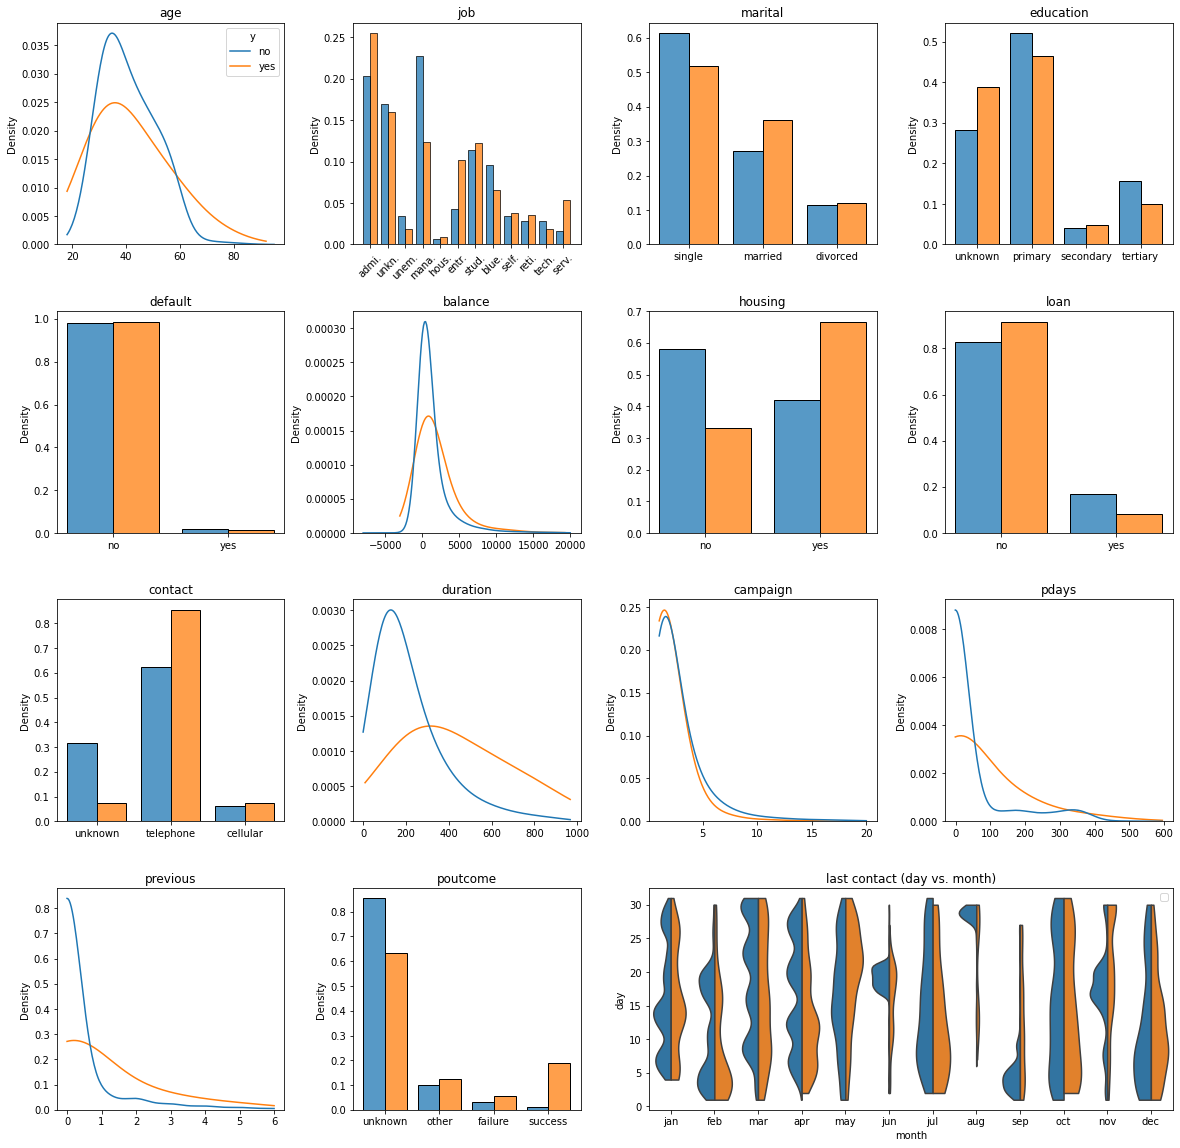

In [46]:
## Plot data distribution
df, features = load_df(raw=False, debug=True)
y = df.y
df = df.drop(columns='y')

plt.figure(figsize = (20, 20))
grid = plt.GridSpec(4, 4, wspace=.3, hspace=.3)

for i, (name, values) in enumerate(df.drop(columns=['day', 'month']).items()):
    ax = plt.subplot(grid[i//4, i%4])
    if features[name]['type'] == 'numerical':
        sns.kdeplot(x=values, hue=y, multiple='layer', common_norm=False, ax=ax, bw_adjust=3.5, cut=0, legend=True if i==0 else False)
    else: #if features[name]['type'] == 'odrinal':
        df[name] = df[name].map({feat: i for i, feat in enumerate(features[name]['classes'])})
        sns.histplot(x=values, hue=y, multiple='dodge', stat='density', shrink=.8, common_norm=False, ax=ax, legend=False)
        ax.set_xticks(np.arange(len(features[name]['classes'])))
        if name == 'job':
            ax.set_xticklabels([f[:4]+'.' for f in features[name]['classes']], rotation=45)
        else:
            ax.set_xticklabels(features[name]['classes'])
    ax.set_title(name)
    ax.set_xlabel('')

ax = plt.subplot(grid[3,2:])
sns.violinplot(data=df, x='month', y='day', hue=y, split=True, inner=None, ax=ax, cut=0, legend=False)
ax.set_xticks(np.arange(len(features['month']['classes'])))
ax.set_xticklabels(features['month']['classes'])
ax.set_title('last contact (day vs. month)')
ax.legend([])
plt.savefig('data/report.jpg')
plt.savefig('data/report.png')
plt.show()

## Model

This section collects the methods relative to the model and the prediction flow.

The methods are called sequentially

1) **Preprocessing**: the input dictionary with the raw data (string and integer values) are encoded to have only numerical data.
    The features are processed as followed:
    - *Ordinal Categorical* features are mapped as incremental integer
    - *Categorical* features are One-Hot encoded
    - *Numerical* features don't need any processing <!--are normalized between (0, 1)-->
 
2) **Classifier**: the input is processed by the classifier, which compute the scores.

3) **Postprocessing**: the output scores is classified wrt a computed threshold

4) **Evaluation**: the output is compared with the ground truth to compute the metrics and the performance plots.

In [5]:
## PREPROCESS AND POSTPROCESS

def preprocess(df:pd.DataFrame, features:dict) -> pd.DataFrame:
    """ Encode the categorical input data

    Args:
        df (pd.DataFrame): raw input data
        features (dict): features specifications

    Raises:
        Exception: Unknown data type

    Returns:
        pd.DataFrame: encoded input data
    """
    if type(df) == dict:
        df = pd.DataFrame(df)
    
    for name, value in df.items():
        if name not in features:
            raise Exception("Unknown features", name)
        # map each class to an incremental integer
        if features[name]['type'] == 'ordinal':
            df[name] = df[name].map({feat: i for i, feat in enumerate(features[name]['classes'])})
        # one hot encode the categorical features
        elif features[name]['type'] == 'categorical':
            for label in features[name]['classes']:
                df[f'{name}_{label}'] = np.where(value==label, 1, 0)
            df = df.drop(columns=name)
        # normalize the numerical data
        elif features[name]['type'] == 'numerical':
            continue
            # not necessary in random forest algorithm
            if 'max' in features[name] and features[name]['max'] is not None:
                max_value = features[name]['max']
                if max_value < 1: max_value = df[name].quantile(max_value)
                df[name] = df[name] / max_value

    return df
    

def postprocess(y_score:np.ndarray, threshold:float=0.5) -> np.ndarray:
    """ Return the predicted class from the score and the threshold

    Args:
        y_score (np.ndarray): output scores
        threshold (float, optional): discriminative threshold between the classes' scores. Defaults to 0.5.

    Returns:
        np.ndarray: prediction array
    """
    return np.where(y_score >= threshold, 1, 0)

In [17]:
## PLOTTING METHODS

def f1_score_curve(y_true:np.ndarray, y_score:np.ndarray) -> tuple:
    """Compute the F1 score for different threshold

    Args:
        y_true (np.ndarray): True binary labels
        y_score (np.ndarray): Computed scores

    Returns:
        f1 (np.ndarray): f1 scores such that the element i is the f1 score of elements with score >= threshold[i]
        threshold (np.ndarray): increasing threshold on the decision function
    """
    prec, recall, thr = precision_recall_curve(y_true, y_score)
    f1 = 2 * prec * recall / (prec + recall + np.e)
    return f1, thr


def plot_roc_curve(y_true:np.ndarray, y_score:np.ndarray, best_thr:float=None, title:str='ROC curve', ax:plt.Axes=None):
    """ROC curve visualization

    Args:
        y_true (np.ndarray): True binary labels
        y_score (np.ndarray): Computed scores
        best_thr (float, optional): Best threshold found, used to plot its position. Defaults to None.
        title (str, optional): Plot title. Defaults to 'ROC curve'.
        ax (plt.Axes, optional): Axes where to draw the plot, if None a new figure is created. Defaults to None.
    """
    if ax is None: fig, ax = plt.subplot()
    fpr, tpr, thr = roc_curve(y_true, y_score)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
    ax.plot([0, 1], [0, 1], '--k') # base line
    if best_thr:
        idx = np.argmin(np.abs(thr - best_thr))
        ax.scatter(fpr[idx], tpr[idx], label=f'thr = {best_thr:.2f}')
    ax.set_title(title)
    ax.legend()
    
    
def plot_pr_curve(y_true:np.ndarray, y_score:np.ndarray, best_thr:float=None, title:str='PR curve', ax:plt.Axes=None):
    """Precision-Recall curve visualization

    Args:
        y_true (np.ndarray): True binary labels
        y_score (np.ndarray): Computed scores
        best_thr (float, optional): Best threshold found, used to plot its position. Defaults to None.
        title (str, optional): Plot title. Defaults to 'PR curve'.
        ax (plt.Axes, optional): Axes where to draw the plot, if None a new figure is created. Defaults to None.
    """
    if ax is None: fig, ax = plt.subplot()
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    display = PrecisionRecallDisplay(prec, rec).plot(ax=ax)
    # baseline
    baseline = len(y_true[y_true==1]) / len(y_true)
    ax.plot([0, 1], [baseline, baseline], '--k')
    if best_thr:
        idx = np.argmin(np.abs(thr - best_thr))
        f1 = 2 * prec[idx] * rec[idx] / (prec[idx] + rec[idx])
        ax.scatter(rec[idx], prec[idx], label=f'thr={best_thr:.2f} (F1={f1:.3f})')
    ax.set_title(title)
    ax.legend()
    
    
def plot_heatmap(y_true:np.ndarray, y_pred:np.ndarray, labels:list[str]=None, title:str='Confusion Matrix', ax:plt.Axes=None):
    """Confusion matrix heatmap visualization

    Args:
        y_true (np.ndarray): True binary labels
        y_pred (np.ndarray): Computed predictions
        labels (list[str], optional): Display labels for plot. If None, display labels are set from 0 to n_classes - 1. Defaults to None.
        title (str, optional): Plot title. Defaults to 'Confusion matrix'.
        ax (plt.Axes, optional): Axes where to draw the plot, if None a new figure is created. Defaults to None.
    """
    if ax is None: fig, ax = plt.subplot()
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    display = ConfusionMatrixDisplay(cm, display_labels=labels)
    display.plot(ax=ax, cmap='Blues', values_format='.3f')
    ax.set_title(title)
    
    
def plot_metrics(y_true:np.ndarray, y_score:np.ndarray, best_thr:float, labels:list[str]=None, savefig:str=None):
    """Plot in a single figure ROC, PR curve and confusion matrix heatmap

    Args:
        y_true (np.ndarray): True binary labels
        y_score (np.ndarray): Computed scores
        best_thr (float): Best threshold found, used to predict the class.
        labels (list[str], optional): Display labels for plot. Defaults to None.
        savefig (str, optional): path to export the figure. If None it's not saved. Defaults to None.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    y_pred = postprocess(y_score, best_thr)
    plot_roc_curve(y_true, y_score, best_thr, title=f'ROC curve (AUC={roc_auc_score(y_true, y_score):.2f})', ax=axs[0])
    #plot_pr_curve(y_true, y_score, best_thr, ax=axs[1])
    plot_heatmap(y_true, y_pred, labels, title=f'confusion matrix (thr = {best_thr:.2f})', ax=axs[1])
    if savefig: plt.savefig(savefig)
    plt.show()

In [22]:
## TRAIN/TEST/LOAD MODEL

def train(config:dict, train_df:pd.DataFrame) -> XGBClassifier:
    """Train new model

    Args:
        config (dict): Hyper-parameters configuration
        train_df (pd.DataFrame): train dataset

    Returns:
        XGBClassifier: trained model
    """
 
    model = XGBClassifier(**config)
    model.fit(train_df.drop(columns='y'), train_df.y)
    return model


def load(model_path:str) -> XGBClassifier:
    """Load trained model

    Args:
        model_path (str): path to model (.bst)

    Returns:
        XGBClassifier: loaded model
    """
    assert Path(model_path).is_file(), "Not such file"
    model = XGBClassifier()
    model.load_model(model_path)
    return model


def evaluate(model:XGBClassifier, test_df:pd.DataFrame, labels:list[str]=['no', 'yes'], plot:bool=False, savefig:str=None, hyperopt_report:bool=False) -> Union[float, dict]:
    """Evaluate the model on the test set. It's possible to plot and export the reuslts

    Args:
        model (XGBClassifier): trained model to evaluate
        test_df (pd.DataFrame): test dataset
        labels (list[str], optional): output labels, for plotting. Defaults to ['no', 'yes'].
        plot (bool, optional): plot the results. Defaults to False.
        savefig (str, optional): export the plot. Defaults to None.
        hyperopt_report (bool, optional): return a dict compatible with the HyperOpt object. Defaults to False.

    Returns:
        if hyperopt_report: 
            float: objective function to minimize
        else:
            dict: metrics dictionary
    """    
    y_true = test_df.y
    y_score = model.predict(test_df.drop(columns='y'), output_margin=True)
    auc = roc_auc_score(y_true, y_score)
    
    # HyperOpt implements only a minimization function, 
    # to maximize the AUC score it's multipled by -1
    if hyperopt_report: return -auc
    
    # compute the best threshold for the confusion matrix
    fpr, tpr, thr = roc_curve(y_true, y_score)
    best_thr = thr[np.argmin(fpr-tpr)]
    y_pred = postprocess(y_score, best_thr)
    
    if plot:
        print(classification_report(y_true, y_pred, digits=3, target_names=labels))
        print('AUC', auc)
        plot_metrics(y_true, y_score, best_thr, labels, savefig=savefig)
    metrics = classification_report(y_true, y_pred, digits=3, target_names=labels, output_dict=True)
    metrics['AUC'] = float(auc)
    metrics['threshold'] = float(best_thr)
    return metrics
    

## Pipelines

General pipelines useful to automatize the processes.

In [8]:
## LOAD & TRAIN PIPELINE

def load_df_pipeline(data_path:str='data/bank-dataset.csv', features_path:str='data/features.yaml', test_size:float=.2, seed:int=None) -> tuple:
    """Pipeline to load the dataset and split into train and test set

    Args:
        data_path (str, optional): relative path to data.csv. Defaults to 'data/bank-dataset.csv'.
        features_path (str, optional): relative path to feature specs. Defaults to 'data/features.yaml'.
        test_size (float, optional): If <1 portion of dataset for test, else samples to use for test. Defaults to .2.
        seed (int, optional): random seed for reproducibility. Defaults to None.

    Returns:
        pd.DataFrame: preprocessed train set
        pd.DataFrame: preprocessed test set
    """
    df, features = load_df(data_path, features_path)
    df = preprocess(df, features)
    train_df, test_df = train_test_split(df, test_size=test_size, stratify=df.y, random_state=seed)
    return train_df, test_df


def train_pipeline(config:dict, 
                   data_path:str='data/bank-dataset.csv', 
                   features_path:str='data/features.yaml', 
                   test_size:float=.2, seed:int=None, 
                   logdir:str=None) -> tuple:
    """Pipeline to train and evaluate the model from the configuration

    Args:
        config (dict): Hyper-parameters configuration
        data_path (str, optional): relative path to data.csv. Defaults to 'data/bank-dataset.csv'.
        features_path (str, optional): relative path to feature specs. Defaults to 'data/features.yaml'.
        test_size (float, optional): If <1 portion of dataset for test, else samples to use for test. Defaults to .2.
        seed (int, optional): random seed for reproducibility. Defaults to None.
        plot (bool, optional): plot the results. Defaults to False.
        savefig (str, optional): export the plot. Defaults to None.

    Returns:
        XGBClassifier: trained model
        dict: metrics dictionary
    """
    train_df, test_df = load_df_pipeline(data_path, features_path, test_size, seed)
    train_df = midsampling(train_df, 'y', seed)
    model = train(config, train_df)
    
    if logdir:
        model.save_model(logdir/'model.bst')
        metrics = evaluate(model, test_df, plot=True, savefig=logdir/'stats.png')
        with open(logdir/'metrics.yaml', 'w') as outfile: yaml.dump(metrics, outfile, default_flow_style=False)
    else:
        metrics = evaluate(model, test_df, plot=True)
    return model, metrics

In [9]:
## CROSS VALIDATION

def cross_validation(config:dict, df:pd.DataFrame, seed:int=None, labels:list[str]=['no', 'yes'], hyperopt_report:bool=False):
    """Cross validate a configuration by training and validate the model on different train/val sets.

    Args:
        config (dict): Hyper-parameters configuration
        df (pd.DataFrame): dataset, splitted in train and validation set
        seed (int, optional): random seed fro reproducibility. Defaults to None.
        labels (list[str], optional): output labels, for plotting. Defaults to ['no', 'yes'].
        hyperopt_report (bool, optional): return a dict compatible with the HyperOpt object. Defaults to False.

    Returns:
        dict: {'loss': metric_to_minimize, 'status:'ok'}
            Report required by HyperOpt minimization function to evaluate the configuration
        XGBClassifier: trained models
        metrics: computed metrics
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    cross_models, cross_metrics = [], None

    for train_ids, val_ids in skf.split(df.drop(columns='y'), df.y):
        # prepare the datsets for this train, from the idexes computed by StratifiedKFold object
        train_df, val_df = df.iloc[train_ids], df.iloc[val_ids]
        train_df = midsampling(train_df, 'y', seed)
        model = train(config, train_df)
        metrics = evaluate(model, val_df, labels, hyperopt_report=hyperopt_report)
        
        # collect the train results according the return kind
        if hyperopt_report:
            if cross_metrics is None: cross_metrics = []
            cross_metrics.append(metrics)
        else:
            cross_models.append(model)
            if cross_metrics is None:
                cross_metrics = {}
                for key1, val1 in metrics.items():
                    if type(val1) == dict:
                        cross_metrics[key1] = {key2: [] for key2 in val1.keys()}
                    else: cross_metrics[key1] = []
            for key1, val1 in metrics.items():
                if type(val1) == dict:
                    for key2, val2 in val1.items(): cross_metrics[key1][key2].append(val2)
                else: cross_metrics[key1].append(val1)
    
    if hyperopt_report:
        # HyperOpt implements only a minimization function associated with the metric "loss"
        # to fit this constraint, the score is reported as "loss".
        return {'loss':np.mean(cross_metrics), 'status':'ok'}
    else:
        return cross_models, cross_metrics

In [23]:
## INFERENCE

def inference(model:Union[XGBClassifier, str], input:dict, features:Union[dict, str]='data/features.yaml', threshold:float=None) -> Union[float, str]:
    """Run an inference call with a pretrained model

    Args:
        model (Union[XGBClassifier, str]): Pre-trained model or path to model.bst
        input (dict): input dict
        features (Union[dict, str], optional): relative path to feature specs. Defaults to 'data/features.yaml'.
        threshold (float, optional): discriminative threshold between the classes' scores. Defaults to None.

    Returns:
        float: output score
        str: output class
    """
    xgb_model = load(model) if type(model)==str else model
    if type(features) == str:
        features = yaml.load(open(features, 'r'), Loader=yaml.SafeLoader)
    
    input = preprocess(input, features)
    output = xgb_model.predict(input, output_margin=True)
    if threshold:
        output = postprocess(output, threshold)
        output = np.vectorize({i: feat for i, feat in enumerate(features['y']['classes'])}.get)(output)
    
    return output

## Hyper-parameter optimization

To obtain the best performances, the hyper-parameters requires to be tuned. The library **HyperOpt** offers an easy way to find the best hyper-parameters, setting the value range for each parameter.

The dataset is initially splitted into train and test set, then each proposal is evaluated with the K-fold cross-validation, thus the configuration's metric will be the average of k indipendent trains.

In [11]:
## TRIALS EVOLUTION PLOT

def plot_trials(trials_score:np.ndarray, logdir:str):
    """Plot performace evolution along the Hyper Optimization

    Args:
        trials_score (np.ndarray): trials obtained
        logdir (str): _description_
    """
    # compute step line with the max score reached
    curr_max, history_max = trials_score[0], []
    for score in trials_score:
        if score > curr_max: curr_max = score
        history_max.append(curr_max)
        
    sns.scatterplot(data=trials_score, label='proposal AUC')
    sns.lineplot(data=history_max, label='best AUC', drawstyle='steps-post')
    plt.ylabel('AUC')
    plt.xlabel('proposals')
    plt.title('Hyper-parameter evolution')
    plt.legend()
    plt.savefig(logdir/'trials.png')
    plt.show()

100%|██████████| 200/200 [48:30<00:00, 14.55s/trial, best loss: -0.9321080559237306]


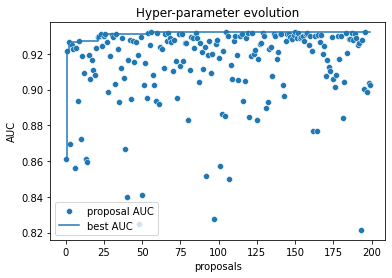

              precision    recall  f1-score   support

          no      0.994     0.786     0.878      7665
         yes      0.228     0.933     0.366       520

    accuracy                          0.795      8185
   macro avg      0.611     0.859     0.622      8185
weighted avg      0.946     0.795     0.845      8185

AUC 0.9282277083646947


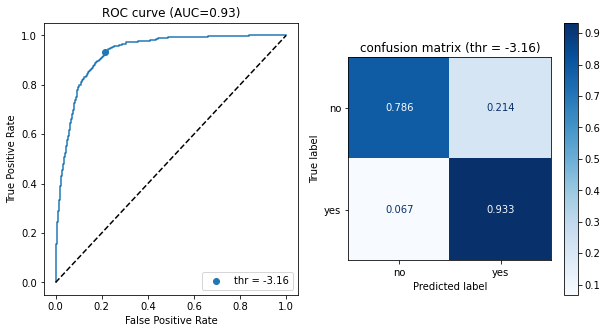

In [12]:
data_path = 'data/bank-dataset.csv'
features_path = 'data/features.yaml'

train_df, test_df = load_df_pipeline(data_path, features_path, test_size=.2, seed=SEED)
samples = train_df.y.value_counts()

# Configuration space: specify interval and type for every parameter
config = {
    'eval_metric': 'auc',
    'max_depth': 3 + hp.randint('max_depth', 50),
    'n_estimators': 30 + hp.randint('n_estimators', 500),
    'eta': hp.loguniform('eta', -6, -1),
    'subsample': hp.uniform('subsample', 0.1, 1.0),

    'colsample_bytree': hp.uniform('colsample_bytree', .01, 1.0),
    'colsample_bylevel': hp.uniform('colsample_bylevel', .01, 1.0),
    'colsample_bynode': hp.uniform('colsample_bynode', .01, 1.0),
    'gamma': hp.uniform ('gamma', 0, 9),
    'min_child_weight': hp.randint('min_child_weight', 10),
    
    'alpha': hp.uniform('alpha', 0, 3),
    'lambda': hp.uniform('lambda', 0, 3),
    'scale_pos_weight': samples[0] / samples[1]
}

# Prepare logging directory
logdir = Path('results')/datetime.now().strftime("%m%d-%H%M%S")
logdir.mkdir()

# Run HyperOpt with cross validation
trials = Trials()
best_hyperparams = fmin(fn = lambda cfg: cross_validation(cfg, train_df, hyperopt_report=True, seed=SEED),
                        space = config,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials,
                        verbose=1)

# Export data about the HyperOpt
with open(logdir/'best_hyperparams.yml', 'w') as outfile:
    yaml.dump(best_hyperparams, outfile, default_flow_style=False)
plot_trials(-np.array(trials.losses()), logdir)
    
# Once the best hyper-parameters have been found, train the final model with the whole train set
# and evaluate its performance on the test set
model, metrics = train_pipeline(best_hyperparams, data_path, features_path, test_size=.2, seed=SEED, logdir=logdir)
    

## Inference

In [24]:
samples = {
    'age': [58, 150, 42],
    'job': ['management', 'student', 'admin.'],
    'marital': ['married', 'single', 'single'],
    'education': ['tertiary', 'secondary', 'secondary'],
    'default': ['no', 'no', 'no'],
    'balance': [2143, 0, -247],
    'housing': ['yes', 'no', 'yes'],
    'loan': ['no', 'no', 'yes'],
    'contact': ['unknown', 'cellular', 'telephone'],
    'day': [5, 6, 21],
    'month': ['may', 'feb', 'oct'],
    'duration': [261, 229, 519],
    'campaign': [1,6, 1],
    'pdays': [-1, -1, 166],
    'previous': [0, 0, 1],
    'poutcome': ['unknown', 'unknown', 'other']
} # y = ['no', 'yes', 'yes']

output = inference('results/1025-184603/model.bst', samples, threshold=-3.16)
print(output)

['no' 'yes' 'yes']
